# Visualization of the Pb boundary conditions based on transects

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmocean
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

#### Parameters

In [6]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,778,798) # Northern Canada Basin 
bdy_WCB = (2168,2178,390,797) # Western Canada Basin 
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,293,303) # Hudson Bay

# Colors
land_color = '#a9a7a2'

#### Files

In [7]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [8]:
# Boundary condition file for grid coordinates (created with notebook forcing/create-TS-based-BCs.ipynb)
# BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC_y2002m01.nc','r')
BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb-tuning-202303/Pb_OBC_y2002m01.nc','r')
dPb_S  = np.array(BC.variables['dPb_S']).reshape(50,rimwidthS,bdy_LS[3]-bdy_LS[2])
dPb_N  = np.array(BC.variables['dPb_N']).reshape(50,rimwidthN,bdy_WCB[3]-bdy_WCB[2])
dPb_E  = np.array(BC.variables['dPb_E']).reshape(50,rimwidthE,bdy_NCB[1]-bdy_NCB[0])
dPb_W  = np.array(BC.variables['dPb_W']).reshape(50,rimwidthW,bdy_HB[1]-bdy_HB[0])

# Labrador Sea
dPb_S_lons = mesh_lon[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]] 
dPb_S_lats = mesh_lat[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
dPb_S_mdepths = bathy_masked[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]

# Northern Canada Basin
dPb_E_lons = mesh_lon[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_lats = mesh_lat[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_mdepths = bathy_masked[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 

# Western Canada Basin
dPb_N_lons = mesh_lon[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]] 
dPb_N_lats = mesh_lat[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
dPb_N_mdepths = bathy_masked[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]

# Hudson Bay
dPb_W_lons = mesh_lon[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_lats = mesh_lat[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_mdepths = bathy_masked[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 

BC.close()

Load multi-month boundaries:

In [16]:
dPb_S_monthly = np.empty((12,50,10,226))

for month in range(1,13):
    BC     = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-tuning-202303/Pb_OBC_y2015m{month:02}.nc','r')
    dPb_S_monthly[month-1,:,:,:] = np.array(BC.variables['dPb_S']).reshape(50,10,226)
    BC.close()

#### Functions

In [17]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [18]:
def plot_transect(ax, variable, vrange=(30,35), label='', cmap=cmocean.cm.deep, labelling=True):
    
    ax.invert_yaxis()
    ax.set_ylim(4000, -60)
    ax.set_xlim(0, 1100)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    # plot model boundary condition:
    bdy_cell = 0
    xx, zz = np.meshgrid(S_distance, depths)
    CB1 = ax.pcolormesh(xx, zz, variable[:,bdy_cell,:], vmin=vrange[0], vmax=vrange[1], cmap=cmap)
    ax.pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))
    
    return CB1

#### Calculations

In [19]:
# Look at only one slice of the rimwidth thickness boundary:
S_distance  = calc_distance(dPb_S_lats[-1,:]   , dPb_S_lons[-1,:])    # Labrador Sea
N_distance  = calc_distance(dPb_N_lats[-1,:]   , dPb_N_lons[-1,:])    # western CB
E_distance  = calc_distance(dPb_E_lats[:,-1], dPb_E_lons[:,-1])       # northern CB
W_distance  = calc_distance(dPb_W_lats[:,-1], dPb_W_lons[:,-1])       # Hudson Bay

#### Figures

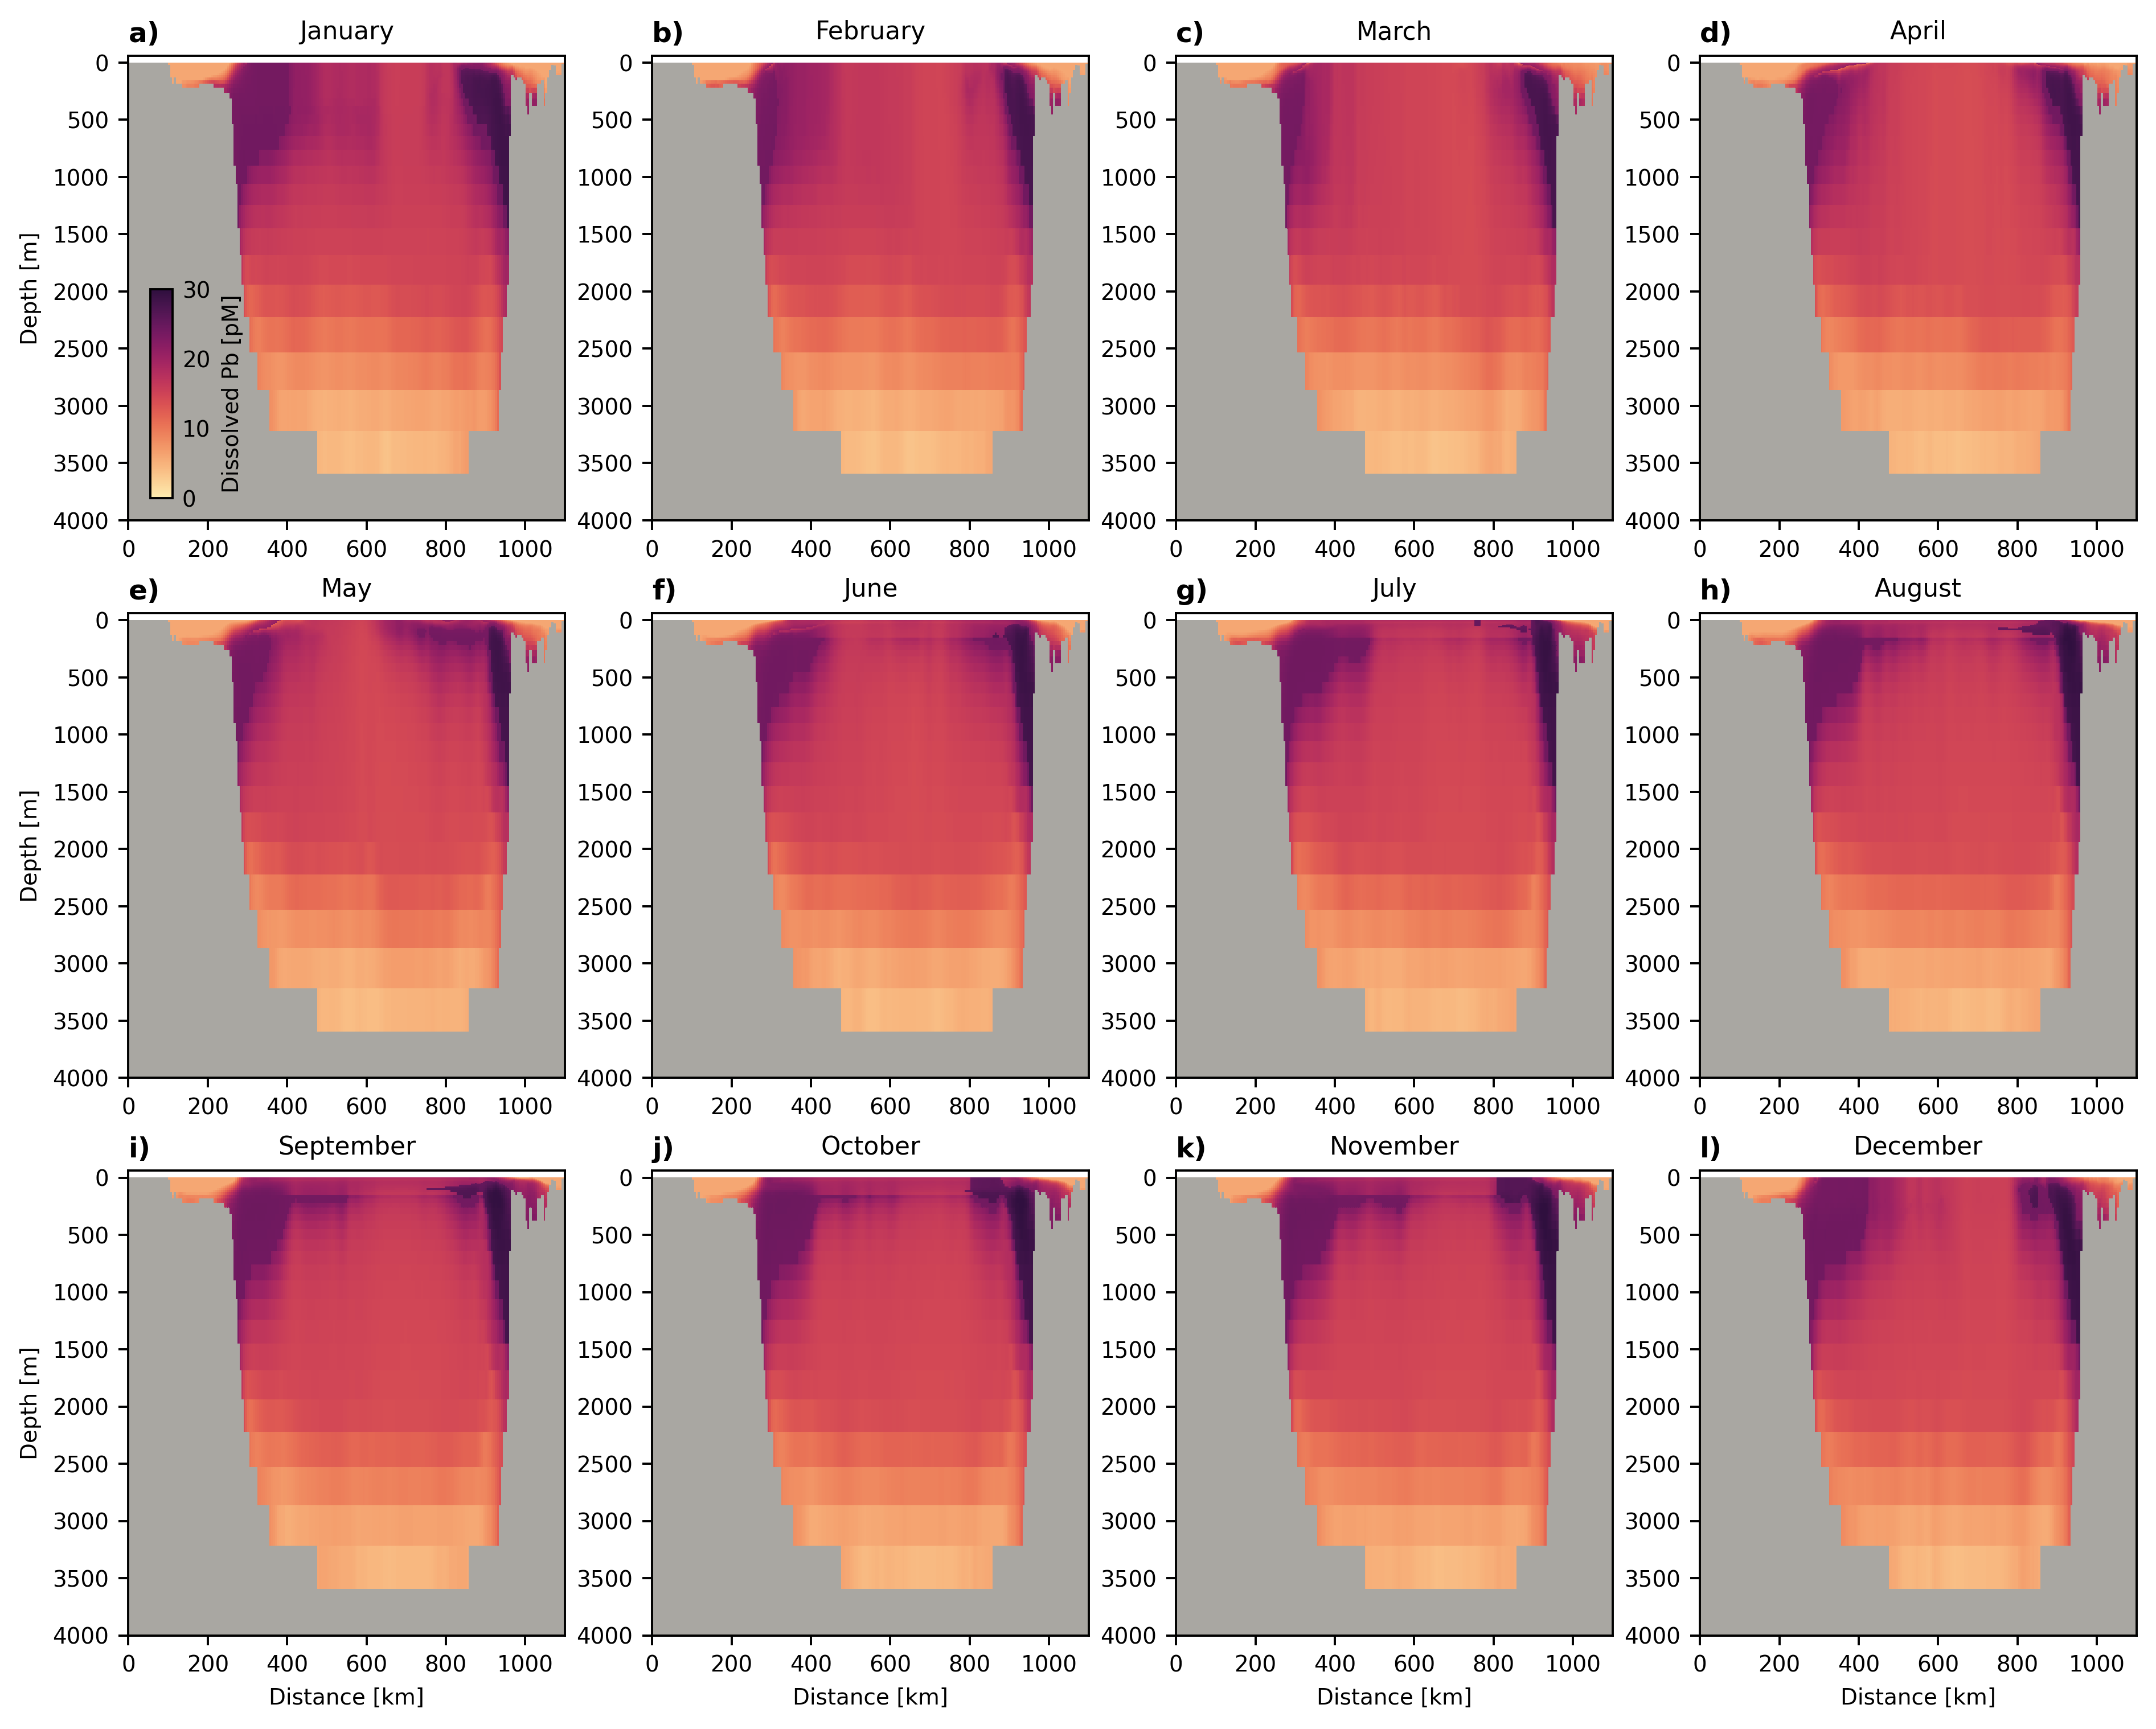

In [21]:
fig, ax = plt.subplots(3,4, figsize=(13, 10.5), dpi=350)

axes = ax.ravel()
months=['January','February', 'March','April','May','June','July','August','September','October','November','December']
labels=['a)','b)','c)','d)','e)','f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']

for month in range(0,12):
    CB1 = plot_transect(axes[month], dPb_S_monthly[month,:,:,:]*1e12, vrange=(0,30), label='', \
                        cmap=cmocean.cm.matter, labelling=False)
        
    axes[month].set_title(f'{months[month]}', fontsize=9)
    axes[month].text(0, -180, f'{labels[month]}',fontsize=10, weight='bold')
    
# labelling:
for axis in ax[:,0].ravel():
    axis.set_ylabel('Depth [m]', fontsize=8)
    
for axis in ax[2,:].ravel():
    axis.set_xlabel('Distance [km]', fontsize=8)

axins = inset_axes(ax[0,0], width="5%", height="45%", loc='lower left', borderpad=0.8)
CBar  = plt.colorbar(CB1, ax=ax[0,0], cax=axins); 
CBar.set_label(f'Dissolved Pb [pM]', fontsize=8)
CBar.ax.tick_params(axis='y', length=0, labelsize=8)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/S2.jpg', dpi=350, bbox_inches='tight')